# Bedtools Post Hoc Analysis

In [72]:
# librariesss
import pandas as pd
import math
import scipy
import numpy as np
import pyranges as pr
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [73]:
# load in csv identifying individuals, set directory etc
# data: 1000 Genomes on GRCh38,1000 Genomes 30x on GRCh38,Human Genome Structural Variation Consortium, Phase 3,1000 Genomes phase 3 release
hg_pop = pd.read_csv('igsr_samples.csv')  
d = pd.DataFrame()
dir = '/home/oona/nsf_grfp/all_bed/intersect'

In [77]:
# # make sure you're grouping by correct header
# hg00551 = pr.read_bed('/home/oona/nsf_grfp/all_bed/intersect/HG00551_intersect.bed', as_df=True)
# hg00551

In [74]:
# for each file in intersection directory, count the number of ancestry groups per segment and add all to dataframe with HGNum IDs
for bed_file in os.listdir(dir):
    filename = os.path.join(dir, bed_file)
    intersect = pr.read_bed(filename, as_df=True)
    switch_cnt = intersect.groupby(['Name'])['ThickEnd'].count().reset_index(name='count')
    switch_cnt['HGNum'] = os.path.basename(filename)
    d = pd.concat([d, switch_cnt])

In [78]:
# replace the _intersect.bed part of the file ID with nothing, only include rows w/switch count greater than one, compress file and save for reference
d['HGNum'] = d['HGNum'].str.replace('_intersect.bed', '', regex=True)
d = d[d['count'] > 1]

# merge 1000 Genomes identifier csv w/switch count csv we just made to get nationalities, etc for plots
hg_total = pd.merge(d, hg_pop, left_on='HGNum', right_on='Sample name')
# hg_total.to_csv('switch_counts.zip', compression='gzip')

In [124]:
ibd_seg_per_indiv = hg_total.groupby(['HGNum'])['Name'].count().reset_index(name='number of ibd segment intersects')
switch_cnt_per_indiv = hg_total.groupby(['HGNum'])['count'].sum().reset_index(name='total ancestry switches')
ibd_switch_per_indiv = pd.merge(ibd_seg_per_indiv, switch_cnt_per_indiv, left_on='HGNum', right_on='HGNum')
indiv_df = pd.merge(ibd_switch_per_indiv, hg_total[['HGNum','Population code']], on='HGNum', how='left')
indiv_df = indiv_df.drop_duplicates()

### Making Table 1

In [125]:
acb_df = indiv_df[indiv_df['Population code'] == 'ACB']
asw_df = indiv_df[indiv_df['Population code'] == 'ASW']
clm_df = indiv_df[indiv_df['Population code'] == 'CLM']
mxl_df = indiv_df[indiv_df['Population code'] == 'MXL']
pel_df = indiv_df[indiv_df['Population code'] == 'PEL']
pur_df = indiv_df[indiv_df['Population code'] == 'PUR']

In [126]:
# pur_df['number of ibd segment intersects'].describe()
pur_df['total ancestry switches'].describe()

count      104.000000
mean     12673.269231
std        522.959395
min      10322.000000
25%      12527.500000
50%      12695.500000
75%      12989.250000
max      13847.000000
Name: total ancestry switches, dtype: float64

### Plotting

In [128]:
orig_counts = indiv_df.groupby(['Population code'])['total ancestry switches'].sum().reset_index(name='count')

In [129]:
population_counts = orig_counts
pop_counts = [96, 61, 94, 64, 85, 104]
population_counts['count'] = round(orig_counts['count'] / pop_counts)
population_counts

,Population code,count
0,ACB,23826.0
1,ASW,10531.0
2,CLM,10913.0
3,MXL,5913.0
4,PEL,7358.0
5,PUR,12673.0


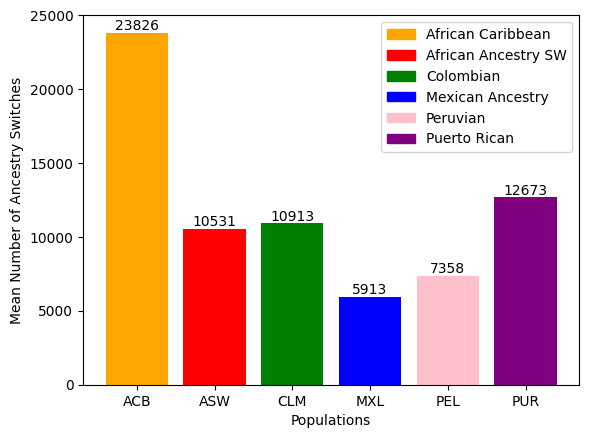

In [130]:
fig, ax = plt.subplots()
my_colors = ['orange', 'red', 'green', 'blue', 'pink', 'purple']
bars = ax.bar(population_counts['Population code'], population_counts['count'], color= my_colors)
# adds counts to top of bar
ax.bar_label(bars) 
acb = mpatches.Patch(color='orange', label='African Caribbean')
asw = mpatches.Patch(color='red', label='African Ancestry SW')
clm = mpatches.Patch(color='green', label='Colombian')
mxl = mpatches.Patch(color='blue', label='Mexican Ancestry')
pel = mpatches.Patch(color='pink', label='Peruvian')
pur = mpatches.Patch(color='purple', label='Puerto Rican')
plt.legend(handles=[acb, asw, clm, mxl, pel, pur])
plt.xlabel("Populations")
plt.ylabel("Mean Number of Ancestry Switches")
plt.savefig("/home/oona/nsf_grfp/figs/seaborn_switch_plot.png")